In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/jiegg/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [3]:
limit_mem()
path = "/home/jiegg/open/data/imagenet-sample-train/my_test/"

In [28]:
img_style = Image.open(path+"style_bic.JPG");img_style
img = Image.open(path+"my_bic.JPG")

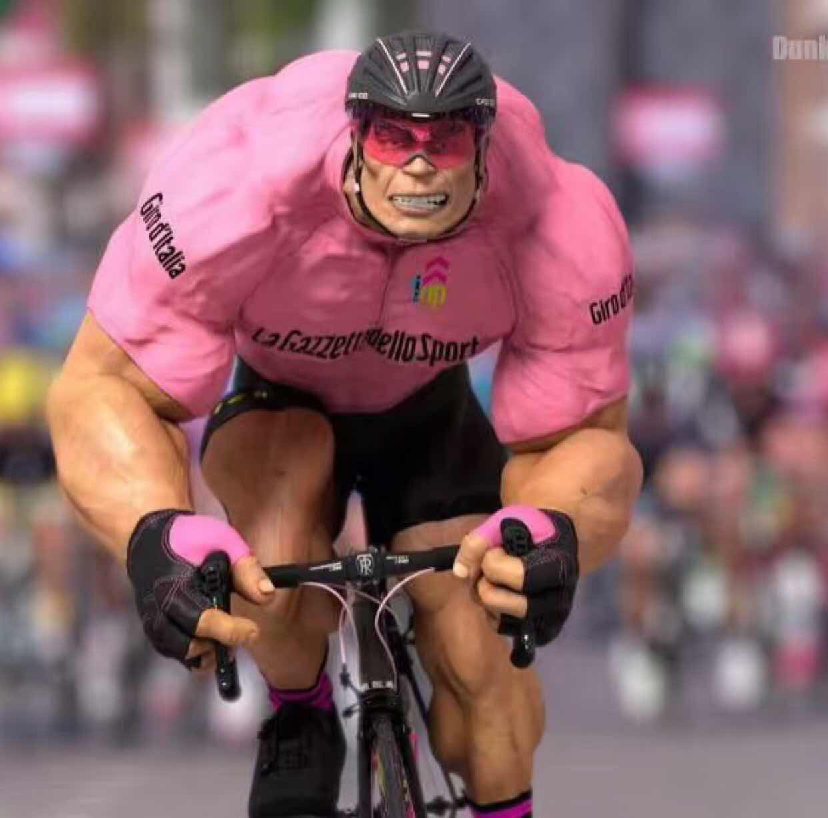

In [29]:
img_style = img_style.resize(np.divide(img_style.size,1.5).astype("int32"));img_style

In [32]:
img.size

(960, 1280)

In [33]:
img_style.size

(828, 818)

### img to arry encode and decode

In [34]:
rn_mean = np.array([123.68,116.779,103.939],dtype=np.float32)
preproc = lambda x:(x-rn_mean)[:,:,:,::-1]
deproc = lambda x,s:np.clip(x.reshape(s)[:,:,:,::-1]+rn_mean,0,255)

In [35]:
img_arr = preproc(np.expand_dims(np.array(img),0))


In [36]:
style_arr = preproc(np.expand_dims(img_style,0)[:,:,:,:3])

In [37]:
style_arr.shape

(1, 818, 828, 3)

In [42]:
w,h = img_style.size

src = img_arr[:,200:200+h,:w]
src.shape
shp = src.shape; shp

(1, 818, 828, 3)

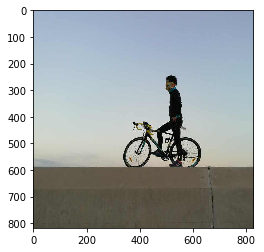

In [43]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype("uint8"))
plot_arr(src)

## Model

In [44]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 818, 828, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 818, 828, 64)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 818, 828, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (AveragePooling2D)   (None, 409, 414, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [45]:
style_layers = [outputs["block{}_conv2".format(o)] for o in range (1,6)]
content_name = "block4_conv2"
content_layer = [outputs[content_name]]# content 使用block4——con2，style使用各层加权

In [46]:
style_model = Model(model.input,style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [47]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [48]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [49]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [50]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [51]:
class Evaluator(object):
    def __init__(self,f,shp): self.f, self.shp=f,shp
        
    def loss(self,x):
        loss_,self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [52]:
evaluator = Evaluator(transfer_fn, shp)

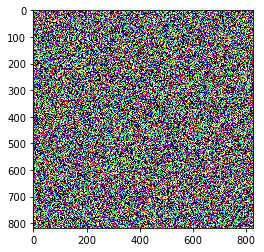

In [53]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);


In [54]:

def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [55]:
iterations=10
x = solve_image(evaluator, iterations, x)

Current loss value: 3013.62890625
Current loss value: 875.358032227
Current loss value: 558.961669922
Current loss value: 401.684020996
Current loss value: 314.18838501
Current loss value: 249.904724121
Current loss value: 217.828460693
Current loss value: 192.984863281
Current loss value: 174.083236694
Current loss value: 158.828964233


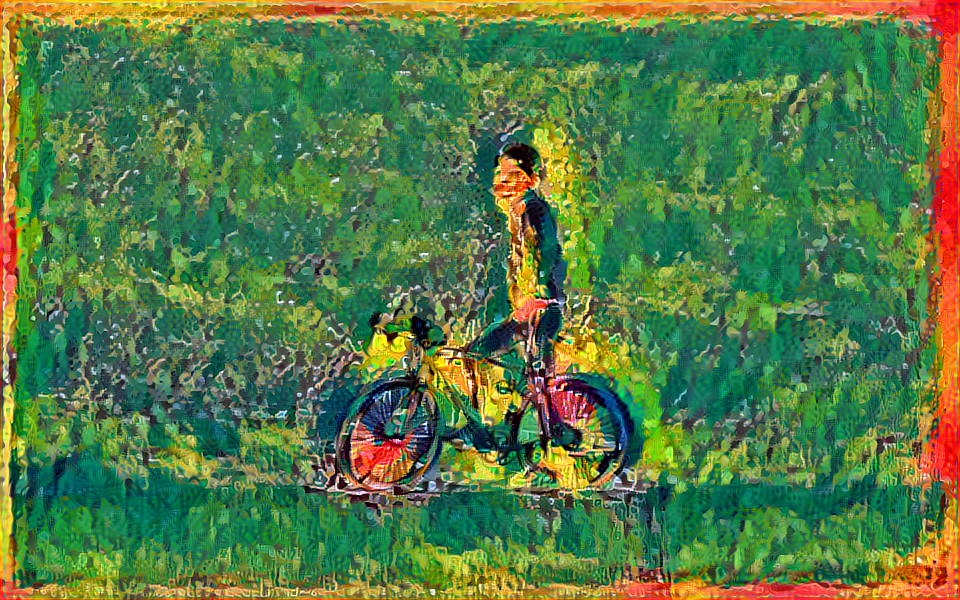

In [26]:
Image.open(path + 'results/res_at_iteration_9.png')